## Title

Background

Question 
We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

Can activity of the players (played hours) predict the characteristic of each player (gender and age)?

Data description

A csv file called `players.csv` is used which contains data of all unique Minecraft players including the following variables:

- `experience`:
- `subscribe`:
- `hashedEmail`:
- `played_hours`:
- `name`:
- `gender`:
- `Age`:
(add data type as well)

There are total of 196 observations and 7 variables.

summary stats

issues: experience and gender should be factor type so that the data can be classified, `hashedEmail` variable is unnecessary - it brings more confusion

how the data was collected?

In [28]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidyclust)
library(tidymodels)
library(recipes)

In [29]:
players <- read_csv("data/players.csv")

# preview of the data file players
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [46]:
# data wrangling

players_clean <- players |>
                select(played_hours, Age) |>
                filter(played_hours != is.na(played_hours) & Age != is.na(Age))

head(players_clean)

played_hours,Age
<dbl>,<dbl>
30.3,9
3.8,17
0.7,21
0.1,21
0.1,17
1.6,23


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


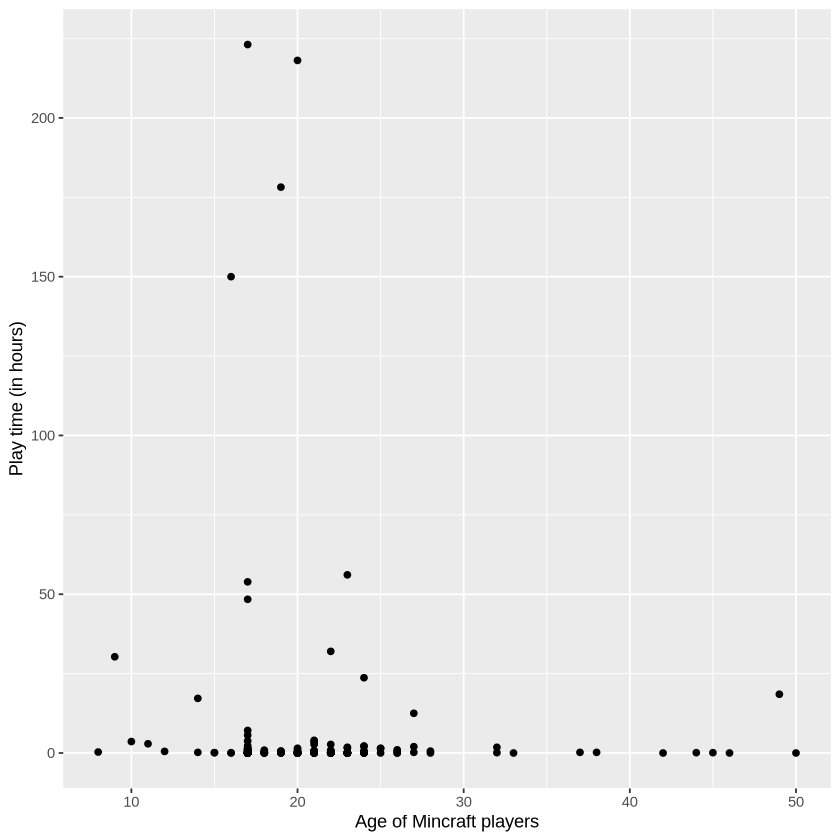

In [41]:
# age vs played_hours and color with gender, experience, subscribe separately.
hours_vs_age <- players_clean |>
            ggplot(aes(x = Age, y = played_hours)) +
            geom_point() + 
            xlab("Age of Mincraft players") +
            ylab("Play time (in hours)") 

hours_vs_age

According to the scatter plot above, it is necessary to scale the axes.

Warning message:
“The `...` are not used in this function but one or more objects were passed: ''”


num_clusters,total_WSSD
<int>,<dbl>
10,5.766570
2,117.435042
9,6.583001
7,11.909461
6,16.933257
8,8.883403
5,22.379269
4,28.279096
3,52.449347


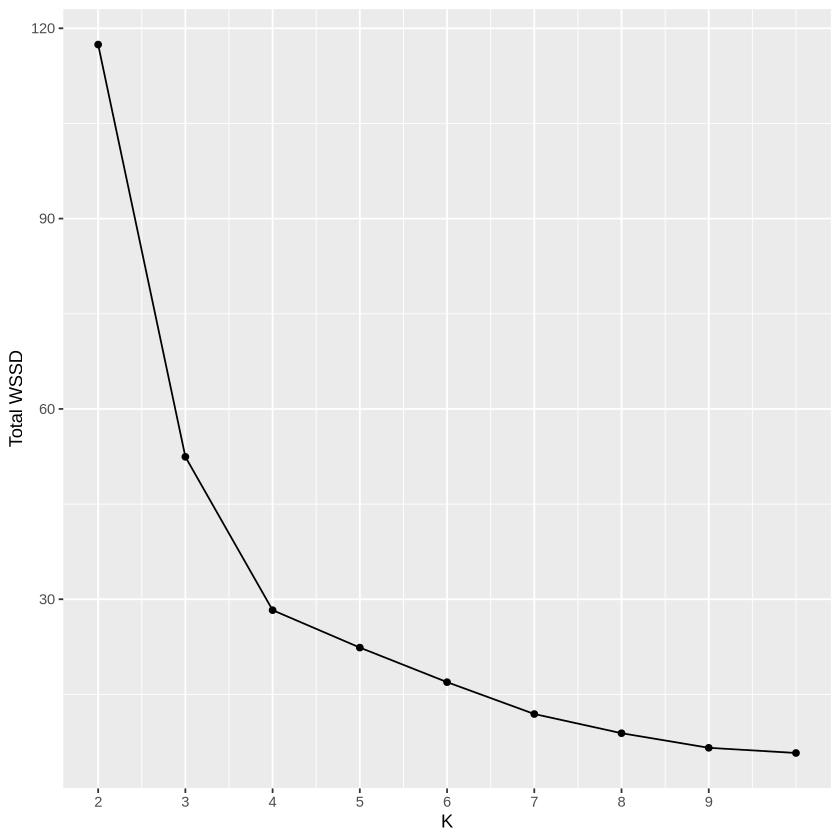

In [72]:
# recipe
kmeans_recipe <- recipe(~., data = players_clean) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors)

# choosing num of k 
k_vals <- tibble(num_clusters = 1:9)

kmeans_spec_tune <- k_means(num_clusters = tune()) |>
            set_engine("stats", nstart = 1000)

kmeans_results <- workflow() |>
                add_recipe(kmeans_recipe) |>
                add_model(kmeans_spec_tune) |>
                tune_cluster(resamples = apparent(players_clean), grid(k_vals)) |>
                collect_metrics() |>
                filter(.metric == "sse_within_total") |>
                mutate(total_WSSD = mean) |>
                select(num_clusters, total_WSSD)

kmeans_elbow <- kmeans_results |>
                ggplot(aes(x = num_clusters, y = total_WSSD)) +
                geom_point() +
                geom_line(group = 1) +
                xlab("K") +
                ylab("Total WSSD") +
                scale_x_continuous(breaks = 1:9)
kmeans_results
kmeans_elbow

number of clusters chosen: K = 4

Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_point()`).”


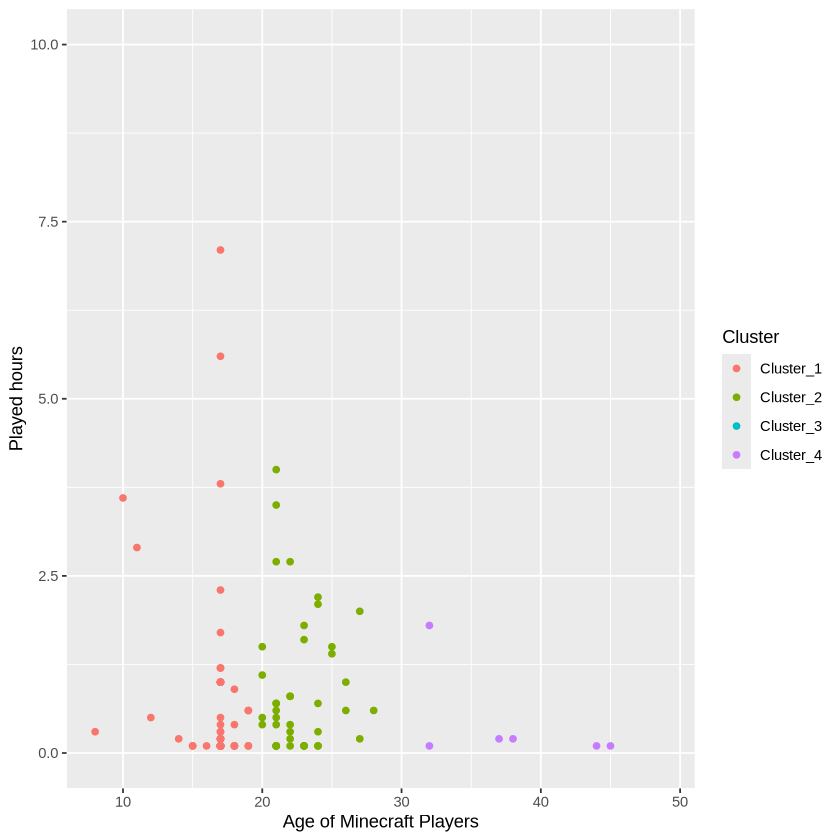

In [75]:
kmeans_spec <- k_means(num_clusters = 4) |>
            set_engine("stats", nstart = 1000) 

kmeans_fit <- workflow() |>
            add_recipe(kmeans_recipe) |>
            add_model(kmeans_spec) |>
            fit(players_clean)

players_clustered <- kmeans_fit |>
                    augment(players_clean)

cluster_plot <- ggplot(players_clustered,
                       aes(x = Age, y = played_hours,
                           color = .pred_cluster)) +
                geom_point() +
                labs(x = "Age of Minecraft Players",
                     y = "Played hours",
                     color = "Cluster") +
                ylim(c(0,10))
cluster_plot